# Tour mode choice 

This notebooks runs 10.000 households (random sample) to calibrate the tour mode choice. It first runs all the models up to "tour_mode_choice_simulate". At this point, we will run a grid search-like algorithm to re-calibrate the coefficients for the tour mode choice
    

In [1]:
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import orca
import time
import geopandas as gpd
import yaml

from activitysim.core import mem
from activitysim.core import inject
from activitysim.core import tracing
from activitysim.core import config
from activitysim.core import pipeline
from activitysim.core import mp_tasks
from activitysim.core import chunk

## Setting configurations files 

In [2]:
#Define injectables
inject.add_injectable('data_dir', 'data')
inject.add_injectable('configs_dir', ['configs', 'configs/configs'])
inject.add_injectable('output_dir', 'output')
# inject.get_injectable('configs_dir')

#Injectables list 
injectables = ['configs_dir', 'data_dir', 'output_dir']

#Configs files
run_list = mp_tasks.get_run_list()

# Injectables to dict 
injectables = list(set(injectables) | set(['data_dir', 'configs_dir', 'output_dir']))
injectables = {k: inject.get_injectable(k) for k in injectables}

## Running model for the first time 

In [3]:
%%time 
# Running models for the first time (current Mode choice specification)
pipeline.run(models = run_list['models'])
pipeline.close_pipeline()

numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_trPkTime * dispersion_parameter_transit)
numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_trOpTime * dispersion_parameter_transit)
numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)


CPU times: user 7min 22s, sys: 41.3 s, total: 8min 3s
Wall time: 5min 16s


## Grid search-like algortighm 

### Big picture: 
- Create a function that calculates the best coefficients 
    grid_search_iterations()
    - Iteration 1: 
        run_time: 
        best_score: 
        score_reduction: 

- Select the variables that I may want to change 
- Create random vectors with those variable (or random search) 
- Try each random vector 
- Define the target distributions (this is very simple because it is just the mode choice share)
- Reduce range for random vector generations (average of the best 10/20th scores) #I need to make this decison 
- Generate new random vectors 
- Try each vector and get restuls 

Diferences from the car_ownership model: 
- This time I take advantage of the modeling framework to run the simulations instead of coding the simulations myself. This is desirable because the mode choice has many variables to look at, and there is not a sinlge table that summarize the variables the model uses. 

In [4]:
def grid_cheker(grids):
    """ Proves if grid has a reasonable shape"""
    assert type(grids) is tuple
    assert isinstance(grids[0], np.ndarray)
    assert isinstance(grids[1], np.ndarray)
    assert isinstance(grids[2], np.ndarray)
    assert grids[0].shape == (216,11)
    assert grids[1].shape == (36, 11)
    assert grids[2].shape == (3,11)

In [5]:
def transpose(df):
    ''' Drops the "atwork subtour colum, and transporse the resutling dataframe"'''
    return df.drop(columns= 'atwork').T

In [6]:
def initialize_grid(coeffs, yaml_file):
    """ Initialize the grids for the ASC, alternative specific and some other constant. 
        Returns:
            - grids: Tuple. Initilazed grids elements. 
                     Tuple with three elements corresponding to ASC, alternative_specific and yaml_file. 
            - attributes: Tuple. Initialzied attributes to produce files of a random selection. 
            
    """
    
    asc_names = ['walk_ASC_no_auto', 'walk_ASC_auto_decicient', 'walk_ASC_auto_sufficient',
            'joint_walk_ASC_no_auto', 'joint_walk_ASC_auto_decicient', 
            'joint_walk_ASC_auto_sufficient', 'sr2_ASC_auto_decicient',
            'sr2_ASC_auto_sufficient', 'sr3p_ASC_no_auto', 
            'sr3p_ASC_auto_decicient','sr3p_ASC_auto_sufficient','walk_transit_ASC_no_auto',
            'walk_transit_ASC_auto_decicient','walk_transit_ASC_auto_sufficient', 
            'drive_transit_ASC_auto_decicient','drive_transit_ASC_auto_sufficient',
            'walk_transit_CBD_ASC', 'drive_transit_CBD_ASC','local_bus_ASC',
            'joint_walk_transit_ASC_no_auto', 'joint_walk_transit_ASC_auto_decicient',
            'joint_walk_transit_ASC_auto_sufficient', 'joint_drive_transit_ASC_auto_decicient',
            'joint_drive_transit_ASC_auto_sufficient']

    cost_names = ['c_wacc', 'c_wegr','c_walktimeshort', 'c_walktimelong']
    
    # Transporse to replace values easily 
    coeffs_t = coeffs.pipe(transpose)
    at_work_coeff = coeffs['atwork'].reset_index(drop = True) #Safe to join later 
    
    #Generate coefficients for ASC
    ASC_shape = coeffs_t[asc_names].shape
    ASC_values = coeffs_t[asc_names].unstack().droplevel(level= 0).astype(float)
    ASC_grid = np.linspace(ASC_values * 0.7, ASC_values * 1.3, 11, axis = 1) #[np.linspace(float(x)* 0.7, float(x) * 1.5, 11) for x in values]
    
    #Generate coeffs for cost_coefficient
    COST_shape = coeffs_t[cost_names].shape
    strings = coeffs_t[cost_names].unstack()#.droplevel(level= 0)
    split = strings.str.split('*', expand = True) # Separated the multiplier and value of time
    COST_values = split[0].astype(float)
    COST_grid = np.linspace(COST_values * 0.7, COST_values * 1.3, 11, axis = 1)#[np.linspace(float(x)* 0.7, float(x) * 1.3, 11) for x in split[0]]
    
    #Modify YAML, file
    costPerMile = yaml_file['CONSTANTS']['costPerMile']
    walkThresh = yaml_file['CONSTANTS']['walkThresh']
    walkSpeed = yaml_file['CONSTANTS']['walkSpeed']
    
    YAML_values = np.array([costPerMile, walkThresh, walkSpeed])
    YAML_shape = YAML_values.shape
    YAML_grid = np.linspace(YAML_values * 0.7, YAML_values * 1.3, 11, axis = 1)#[np.linspace(float(var)* 0.7, float(var) * 1.5, 11) for var in vars_]
    
    grids = np.concatenate((ASC_grid, COST_grid, YAML_grid))
#     attribs = (split, shape_vars, asc_names, cost_coeffs_names,
#                at_work_coeff, coeffs_t, yaml_file, shape_cost, vars_.shape)
    
    attribs = (asc_names, cost_names, yaml_file, ASC_shape, COST_shape, YAML_shape, 
               split, at_work_coeff, coeffs_t)
    
    return grids, attribs

In [7]:
def save_values_to_file(values, attribs):
    """ Saves input files for mode choice given a predetermid set 
        grid"""
    
    #Files
    coeffs_t = attribs[8]
    yaml_file = attribs[2]
    
    #Breakdown grid into its componets
    asc_vars_number = attribs[3][0] * attribs[3][1]
    generic_var_number = attribs[4][0] * attribs[4][1] 
    yaml_var_number = attribs[5][0] 
    
    asc_values = values[:asc_vars_number]
    generic_values = values[asc_vars_number: asc_vars_number + generic_var_number]
    yaml_values = values[asc_vars_number + generic_var_number:]
    
    ##### COEFFS FILE #########
    #ASC replacement     
    coeffs_t[attribs[0]] = np.array(asc_values).reshape(attribs[3], order = 'F') #Replace values in dataframe 
    
    #Cost coefficients replacement
    attribs[6][0] = np.array(generic_values)
    back_to_string = attribs[6][0].astype(str) + '*' + attribs[6][1] 
    coeffs_t[attribs[1]] = back_to_string.unstack().T
    
    #reformat outputfile and save to disk
    coeff_final = coeffs_t.T.reset_index()
    coeff_final['atwork'] = attribs[7]
    save_csv(coeff_final, 'tour_mode_choice_coeffs_v2.csv')
    
    ##### YAML FILE ######### 
#     yaml_values = np.array(yaml_values).reshape(-1)

    yaml_file['CONSTANTS']['costPerMile'] = float(yaml_values[0])
    yaml_file['CONSTANTS']['walkThresh'] = float(yaml_values[1])
    yaml_file['CONSTANTS']['walkSpeed'] = float(yaml_values[2])
    
    yaml_file['COEFFS'] = 'tour_mode_choice_coeffs_v2.csv'
    
    #Saves File to disk
    with open('configs/tour_mode_choice.yaml', 'w') as file:
        documents = yaml.dump(yaml_file, file)

In [50]:
def random_vars(grids, attribs):
    """ Saves input files for mode choice with random coefficient for iterations """
    random_set = [np.random.choice(var, 1, replace = True) for var in grids] #Find a non-loop solution
    save_values_to_file(random_set, attribs)
    
    return np.array(random_set)
    
#     coeffs_t = attribs[8]
#     yaml_file = attribs[2]
#     ##### COEFFS FILE #########
#     #Generating one random coefficient for ASC 
#     asc_set = [np.random.choice(var, 1, replace = True) for var in grids[0]]
#     asc_set_shape = np.array(asc_set).reshape(attribs[3], order = 'F')
#     coeffs_t[attribs[0]] = asc_set_shape #Replace values in dataframe 
    
#     #Generating one random coefficient for cost coefficients 
#     generic_set = [np.random.choice(var, 1, replace = True) for var in grids[1]]
#     attribs[6][0] = np.array(generic_set)
#     back_to_string = attribs[6][0].astype(str) + '*' + attribs[6][1] 
#     coeffs_t[attribs[1]] = back_to_string.unstack().T
    
#     #reformat outputfile 
#     coeff_final = coeffs_t.T.reset_index()
#     coeff_final['atwork'] = attribs[7]
    
#     #Savefile to disk 
#     save_csv(coeff_final, 'tour_mode_choice_coeffs_v2.csv')
    
#     ##### YAML FILE #########
#     assert len(grids[2]) == 3
    
#     yaml_set = [np.random.choice(var, 1, replace = True) for var in grids[2]]
#     yaml_set = np.array(yaml_set).reshape(-1)

#     yaml_file['CONSTANTS']['costPerMile'] = float(yaml_set[0])
#     yaml_file['CONSTANTS']['walkThresh'] = float(yaml_set[1])
#     yaml_file['CONSTANTS']['walkSpeed'] = float(yaml_set[2])
    
#     yaml_file['COEFFS'] = 'tour_mode_choice_coeffs_v2.csv'
    
#     #Saves File to disk
#     with open('configs/tour_mode_choice.yaml', 'w') as file:
#         documents = yaml.dump(yaml_file, file)
        
#     #### Return the randomly choson values
#     return np.concatenate((np.array(asc_set).reshape(-1), np.array(generic_set).reshape(-1), yaml_set))

In [51]:
def run_mode_choice():
    """ Runs mode choice """
    pipeline.run(models = run_list['models'], resume_after = 'non_mandatory_tour_scheduling')
    pipeline.close_pipeline()

In [52]:
def read_results():
    hdf = pd.HDFStore('output/pipeline.h5')
    df = hdf['/tours/tour_mode_choice_simulate']
    hdf.close()
    return df

In [53]:
def score_function(tour_mode):
    ''' Returns the score of the objective function'''
    
    modes_asim = {'WALK_LRF': 'walk_transit', 'WALK_LOC': 'walk_transit', 'SHARED3FREE': 'car', 
                  'WALK_COM': 'walk_transit', 'DRIVEALONEFREE': 'car', 'SHARED2FREE':'car', 
                  'BIKE': 'bike', 'DRIVE_LRF': 'drive_transit', 'WALK': 'walk','WALK_HVY':'walk_transit', 
                  'WALK_EXP':'walk_transit','DRIVE_LOC': 'drive_transit','DRIVE_HVY':'drive_transit', 
                  'DRIVE_COM':'drive_transit','DRIVEALONEPAY':'car', 'SHARED2PAY':'car', 
                  'DRIVE_EXP': 'drive_transit','SHARED3PAY':'car'}
    modes = ['car', 'walk', 'bike', 'walk_transit', 'drive_transit']
    
    tour_mode = tour_mode.replace(modes_asim)
    pct = tour_mode.value_counts()/tour_mode.count()
    
    real_shares = pd.Series(data = [0.8624, 0.0868, 0.0125, 0.0329, 0.0054], index = modes)
    score = np.abs(pct - real_shares).sum() #To change 
    return score

In [89]:
def organize_set(scores, used_values):
    numpy_vector = np.concatenate((scores.reshape((scores.shape[0],-1)), np.squeeze(used_values)), axis = 1)
    return pd.DataFrame(numpy_vector).rename(columns = {0:'score'})

In [90]:
def new_grids(scores, used_values, attribs, top_score_number = 5):
    """ Estimate new limits to generate grids. The new limits are the max and min value 
        of the top 10 best scores
        
        top_score_number: Number of best score that will serve as new grid limits"""
    a = organize_set(scores, used_values)
    b = a.sort_values('score').head(top_score_number).drop(columns = 'score')
    
    #Creates a new grid with min and max values as edges values. 
    max_value = b.max()
    min_value = b.min()
    new_grid = np.linspace(min_value,max_value, 11, axis = 1)
    
#     #Breakdown grid into its componets
#     asc_vars_number = attribs[3][0] * attribs[3][1]
#     generic_var_number = attribs[4][0] * attribs[4][1] 
#     yaml_var_number = attribs[5][0] 
    
    
#     asc_grid = new_grid[1:asc_vars_number + 1]
#     generic_grid = new_grid[asc_vars_number + 1: asc_vars_number + generic_var_number + 1]
#     yaml_grid = new_grid[asc_vars_number + generic_var_number + 1:]
    
#     assert len(yaml_grid == 3)
    
#     grids = (asc_grid, generic_grid, yaml_grid)
    return new_grid

In [91]:
def save_csv(file, name):
    """ saves a csv file"""
    file.to_csv('configs/'+ name, index = False)

In [97]:
def grid_search_(grids, attribs, iterations = 10):
    """ Runs a set of grid search algorithm 
    
    Returns
    - scores: numpy array. shape = (iteration, ) 
    - new_values: numpy array. shape = (iteration, vars). Vars in the number of total coeffs that change. 
    """
    scores_list = []
    used_values_list = []
    for _ in range(iterations):
        start = time.time()
    
        used_values = random_vars(grids, attribs) #Generate file with random values from the grid
#         print(used_values.shape)
        
        run_mode_choice()
        score = score_function(read_results().tour_mode)
        
        scores_list.append(score)
        used_values_list.append(used_values)
        
        end = time.time()
        seconds = end - start
        print('Iteration: {}. Score: {:.5f}. Time: {:.2f}'.format(_,score,seconds))
        
    return np.array(scores_list), np.array(used_values_list)

In [98]:
def grid_search(coeffs, model_settings, iterations = (10,5) , top_score_number = 5):

    print('Initialize ranges')
    grids, attribs = initialize_grid(coeffs, model_settings) #In theory, attributes should not change. 
    last_score, last_value = 1, 0 

    scores_list = []
    coeffs_used = []
    
    
    for _ in range(iterations[0]):
        start = time.time()
        
        scores, used_values = grid_search_(grids, attribs, iterations = iterations[1])
        
        assert len(scores) == len(used_values)
        
        best_score = scores.min()
        best_score_index = scores.argmin()
        best_values = used_values[best_score_index]
        
        grids = new_grids(scores, used_values, attribs, top_score_number)

        improvemnt = np.abs((last_score - best_score)/last_score)
        
        if best_score < last_score:
            last_score = best_score 
            last_values = best_values
        
        end = time.time()
        seconds = end - start
        print('Iteration: {}. Best score: {:.5f}. Time: {:.2f}'.format(_,best_score,seconds))
    
    return last_values, attribs # return best values to recreate files with the given values

In [99]:
def mode_choice_validation(tour_mode):
    ''' Returns the score of the objective function'''
    
    modes_asim = {'WALK_LRF': 'walk_transit', 'WALK_LOC': 'walk_transit', 'SHARED3FREE': 'car', 
                  'WALK_COM': 'walk_transit', 'DRIVEALONEFREE': 'car', 'SHARED2FREE':'car', 
                  'BIKE': 'bike', 'DRIVE_LRF': 'drive_transit', 'WALK': 'walk','WALK_HVY':'walk_transit', 
                  'WALK_EXP':'walk_transit','DRIVE_LOC': 'drive_transit','DRIVE_HVY':'drive_transit', 
                  'DRIVE_COM':'drive_transit','DRIVEALONEPAY':'car', 'SHARED2PAY':'car', 
                  'DRIVE_EXP': 'drive_transit','SHARED3PAY':'car'}
    modes = ['car', 'walk', 'bike', 'walk_transit', 'drive_transit']
    
    tour_mode = tour_mode.replace(modes_asim)
    pct = tour_mode.value_counts()/tour_mode.count()
    
    real_shares = pd.Series(data = [0.8624, 0.0868, 0.0125, 0.0329, 0.0054], index = modes)
    
    #Creating dataframe to organize data to plot
    asim = pd.DataFrame(pct).reset_index()
    asim.columns = ['mode', 'share']
    asim['model'] = 'ActivitySim'
    
    real_shares = pd.DataFrame({'mode':['car', 'walk', 'bike', 'walk_transit', 'drive_transit'], 
                      'share': [0.8624, 0.0868, 0.0125, 0.0329, 0.0054] })
    assert real_shares.share.sum() == 1
    real_shares['model'] = 'Real mode share'
    
    results = pd.concat((asim,real_shares), axis = 0)
    
    #plotting 
    fig, ax = plt.subplots(figsize = (8,5))
    sns.barplot(x='mode', y='share', hue = 'model', data = results.sort_values('share', ascending=False))
    plt.xticks(rotation = 90)
    plt.title('Mode choice - Mode shares')
    plt.ylabel('Mode share - log Scale')
    plt.xlabel('Mode of transportation')
    plt.yscale('log')
    plt.legend(loc = 'upper right')
    
    return results

In [109]:
%%time
coeffs = pd.read_csv('configs/configs/tour_mode_choice_coeffs.csv', 
                     index_col = 'Expression')
#Tour .yaml file 
yaml_file = open('configs/configs/tour_mode_choice.yaml')
model_settings = yaml.load(yaml_file, Loader=yaml.FullLoader)

best_values, attribs = grid_search(coeffs, model_settings, iterations = (20,25), top_score_number = 10)

Initialize ranges


RuntimeError: Pipeline is already open!

## Validation plot 
Plot of mode choice distribution 

To do:
- Get the best values and replace files to run model 
- Run the model with best values 
- obtain the score 
- Plot the resutls versus aggregate distribution 

In [105]:
pipeline.close_pipeline()

In [107]:
save_values_to_file(best_values, attribs)
run_mode_choice()
score = score_function(read_results().tour_mode)
score

AssertionError: 

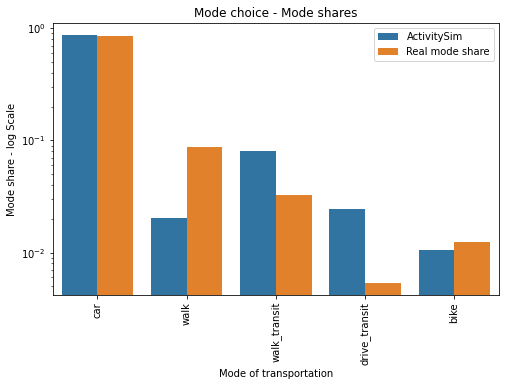

In [108]:
#Tours
asim = mode_choice_validation(tour_mode = read_results().tour_mode)